In [1]:
from __future__ import print_function
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
from numpy import mean
from numpy import std
from numpy import dstack
from numpy import float32,int32
from pandas import read_csv
import pandas as pd
import seaborn as sns
from keras import optimizers

from scipy import stats
from IPython.display import display, HTML

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import TimeDistributed
from keras.utils import np_utils

# Set some standard parameters upfront
pd.options.display.float_format = '{:.1f}'.format
sns.set() # Default seaborn look and feel
plt.style.use('ggplot')
print('keras version ', keras.__version__)
# Same labels will be reused throughout the program
LABELS = ['Downstairs',
          'Jogging',
          'Sitting',
          'Standing',
          'Upstairs',
          'Walking']
# The number of steps within one time segment
TIME_PERIODS = 80
# The steps to take from one segment to the next; if this value is equal to
# TIME_PERIODS, then there is no overlap between the segments
STEP_DISTANCE = 40

def read_data(file_path):

    column_names = ['user-id',
                    'activity',
                    'timestamp',
                    'x-axis',
                    'y-axis',
                    'z-axis']
    df = pd.read_csv(file_path,
                     header=None,
                     names=column_names)
    # Last column has a ";" character which must be removed ...
    df['z-axis'].replace(regex=True,
      inplace=True,
      to_replace=r';',
      value=r'')
    # ... and then this column must be transformed to float explicitly
    df['z-axis'] = df['z-axis'].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss
    # will show up as NAN
    df.dropna(axis=0, how='any', inplace=True)

    return df

def convert_to_float(x):

    try:
        return np.float(x)
    except:
        return np.nan
def show_basic_dataframe_info(dataframe):

    # Shape and how many rows and columns
    print('Number of columns in the dataframe: %i' % (dataframe.shape[1]))
    print('Number of rows in the dataframe: %i\n' % (dataframe.shape[0]))
# Load data set containing all the data from csv
df = read_data('WISDM_ar_v1.1_raw.txt')
# Describe the data
show_basic_dataframe_info(df)
df.head(20)

    
# Define column name of the label vector
LABEL = 'ActivityEncoded'
lables=np.array(LABELS)
# Transform the labels from String to Integer via LabelEncoder
le = preprocessing.LabelEncoder()
# Add a new column to the existing DataFrame with the encoded values
df[LABEL] = le.fit_transform(df['activity'].values.ravel())     
# Differentiate between test set and training set
df_test = df[df['user-id'] > 28]
df_train = df[df['user-id'] <= 28]        

# Normalize features for training data set (values between 0 and 1)
# Surpress warning for next 3 operation
pd.options.mode.chained_assignment = None  # default='warn'
df_train['x-axis'] = df_train['x-axis'] / df_train['x-axis'].max()
df_train['y-axis'] = df_train['y-axis'] / df_train['y-axis'].max()
df_train['z-axis'] = df_train['z-axis'] / df_train['z-axis'].max()
# Round numbers
df_train = df_train.round({'x-axis': 4, 'y-axis': 4, 'z-axis': 4})
                             
# Normalize features for test data set (values between 0 and 1)
# Surpress warning for next 3 operation
pd.options.mode.chained_assignment = None  # default='warn'
df_test['x-axis'] = df_test['x-axis'] / df_test['x-axis'].max()
df_test['y-axis'] = df_test['y-axis'] / df_test['y-axis'].max()
df_test['z-axis'] = df_test['z-axis'] / df_test['z-axis'].max()
# Round numbers
df_test = df_test.round({'x-axis': 4, 'y-axis': 4, 'z-axis': 4})  
def create_segments_and_labels(df, time_steps, step, label_name):

    # x, y, z acceleration as features
    N_FEATURES = 3
    # Number of steps to advance in each iteration (for me, it should always
    # be equal to the time_steps in order to have no overlap between segments)
    # step = time_steps
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['x-axis'].values[i: i + time_steps]
        ys = df['y-axis'].values[i: i + time_steps]
        zs = df['z-axis'].values[i: i + time_steps]
        # Retrieve the most often used label in this segment
        label = stats.mode(df[label_name][i: i + time_steps])[0][0]
        segments.append([xs, ys, zs])
        labels.append(label)

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

def load_dataset(prefix=''):
    x_train, y_train = create_segments_and_labels(df_train,
                                              80,
                                              40,
                                              LABEL)
    x_test, y_test = create_segments_and_labels(df_test,
                                              TIME_PERIODS,
                                              STEP_DISTANCE,
                                              LABEL)

    
    print('x_train shape: ', x_train.shape)
    print(x_train.shape[0], 'training samples')
    print('y_train shape: ', y_train.shape)
    print('x_test shape: ', x_test.shape)
    print(x_test.shape[0], 'test samples')
    print('y_test: ', y_test.shape)  
    # Set input & output dimensions
    num_time_periods, num_sensors = x_train.shape[1], x_train.shape[2]
    num_classes = le.classes_.size
    print('number of classes:',num_classes)
    print(list(le.classes_))
    #OUTPUT:
    #x_train shape:  (20868, 80, 3)
    #20868 training samples
    #y_train shape:  (20868,)
    #x_test shape:  (6584, 80, 3)
    #6584 test samples
    #y_test:  (6584,)
    #number of classes: 6

    input_shape = (num_time_periods*num_sensors)
    #x_train = x_train.reshape(x_train.shape[0], input_shape)
    print('x_train shape:', x_train.shape)
    print('input_shape:', input_shape)
    x_train = x_train.astype('float32')
    y_train = y_train.astype('float32')
    y_train_hot = np_utils.to_categorical(y_train, num_classes)
    print('New y_train shape: ', y_train_hot.shape)
    #OUTPUT:
    #x_train shape: (20868, 240)
    #input_shape: 240
    #New y_train shape:  (20868, 6)
                     
    # Set input & output dimensions
    num_time_periods, num_sensors = x_test.shape[1], x_test.shape[2]
    num_classes = le.classes_.size
    print(list(le.classes_))    
    #input_shape1 = (num_time_periods*num_sensors)
    #x_test = x_test.reshape(x_test.shape[0], input_shape)
    print('x_test shape:', x_test.shape)
    print('input_shape:', input_shape)
    x_test = x_test.astype('float32')
    y_test = y_test.astype('float32')
    y_test_hot = np_utils.to_categorical(y_test, num_classes)
    print('New y_test shape: ', y_test_hot.shape)
    #OUTPUT:
    #x_test shape: (6584, 240)
    #input_shape: 240
    #New y_test shape:  (6584, 6)
    return x_train, y_train, x_test, y_test, y_train_hot, y_test_hot, num_classes
# summarize scores
def summarize_results(scores):
	print(scores)
	m, s = mean(scores), std(scores)
	print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))
    
def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

Using TensorFlow backend.


keras version  2.2.4
Number of columns in the dataframe: 6
Number of rows in the dataframe: 1098203



x_train shape:  (20868, 80, 3)
20868 training samples
y_train shape:  (20868,)
x_test shape:  (6584, 80, 3)
6584 test samples
y_test:  (6584,)
number of classes: 6
['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
x_train shape: (20868, 80, 3)
input_shape: 240
New y_train shape:  (20868, 6)
['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
x_test shape: (6584, 80, 3)
input_shape: 240
New y_test shape:  (6584, 6)
Train on 16694 samples, validate on 4174 samples
Epoch 1/50
16694/16694 [==============================] - 6s 383us/step - loss: 0.7284 - acc: 0.7231 - val_loss: 0.5444 - val_acc: 0.8409
Epoch 2/50
16694/16694 [==============================] - 7s 397us/step - loss: 0.4860 - acc: 0.8190 - val_loss: 0.5248 - val_acc: 0.8194
Epoch 3/50
16694/16694 [==============================] - 6s 383us/step - loss: 0.3740 - acc: 0.8614 - val_loss: 0.5051 - val_acc: 0.8436
Epoch 4/50
16694/16694 [==============================] - 6s 383us/step - los

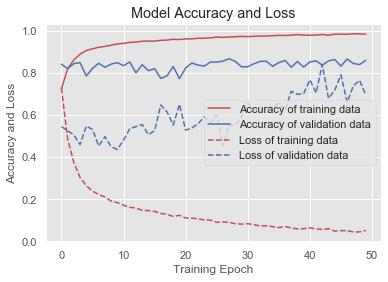

              precision    recall  f1-score   support

         0.0       0.89      0.90      0.90      1864
         1.0       0.99      0.97      0.98      6567
         2.0       0.99      0.99      0.99      1050
         3.0       0.99      1.00      0.99       833
         4.0       0.87      0.93      0.90      2342
         5.0       0.98      0.98      0.98      8212

    accuracy                           0.96     20868
   macro avg       0.95      0.96      0.96     20868
weighted avg       0.97      0.96      0.96     20868



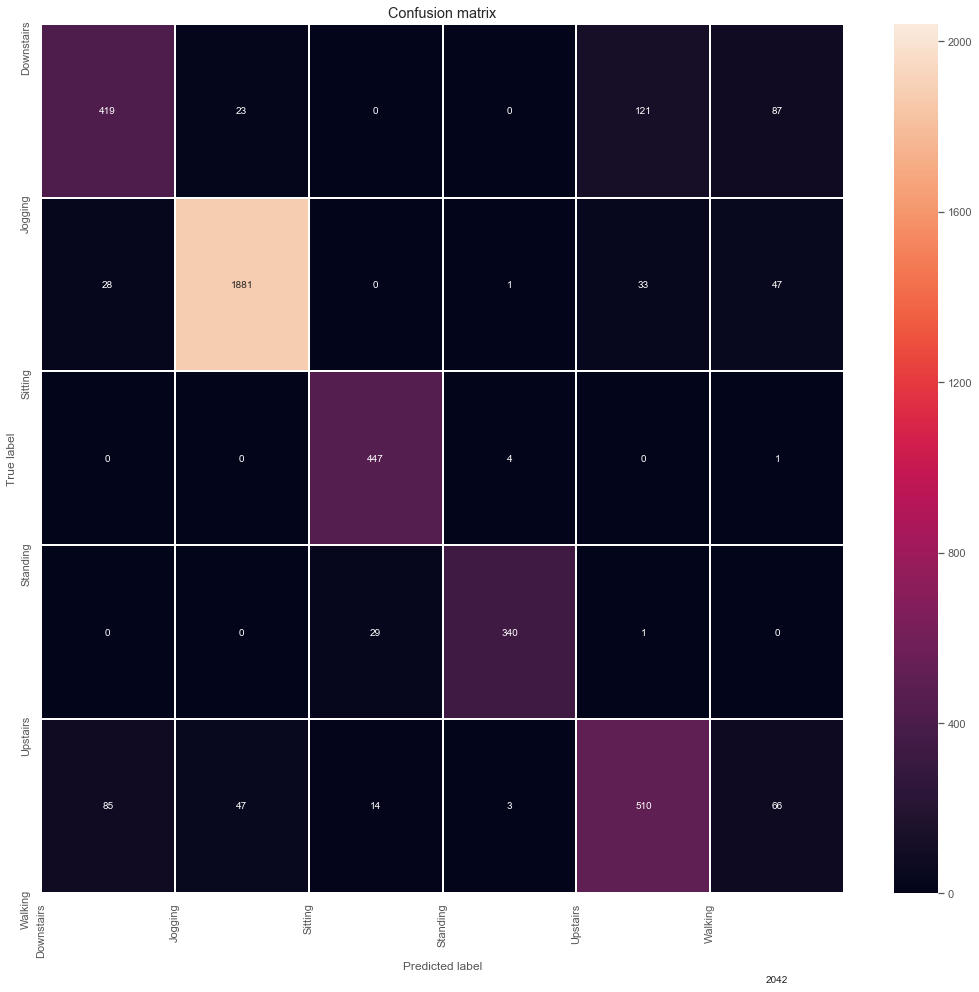

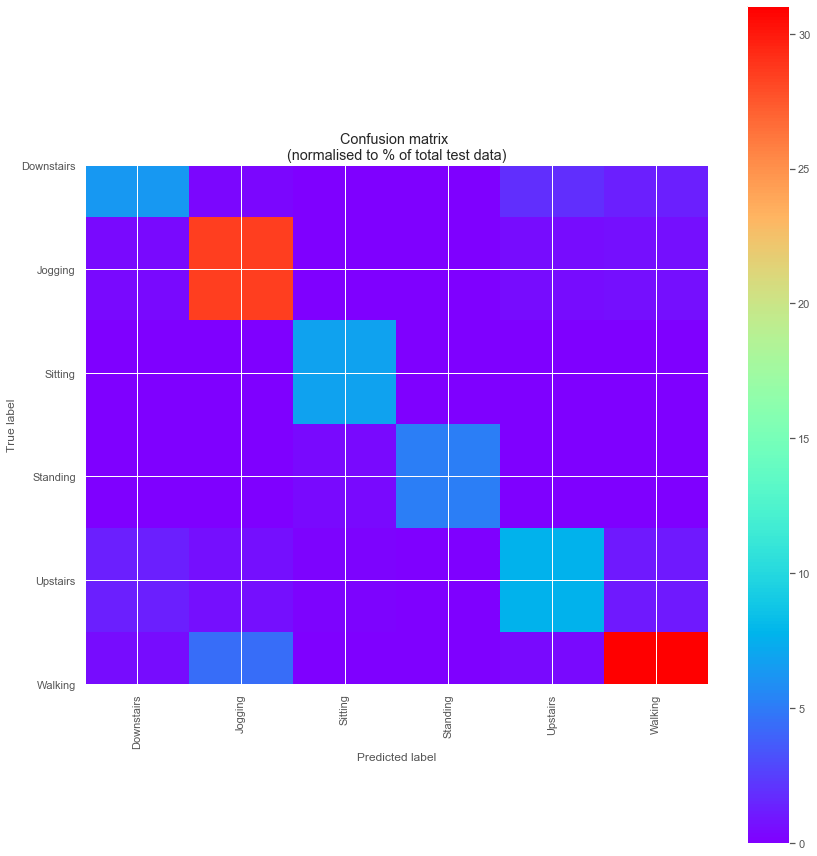

0.8564702308626975
>#1: 85.647
[85.64702308626974]
Accuracy: 85.647% (+/-0.000)


In [2]:
# run an experiment
def run_experiment(repeats=1):
	# repeat experiment
	scores = list()
	for r in range(repeats):
		x_train, y_train, x_test, y_test, y_train_hot, y_test_hot, num_classes = load_dataset()
		tick_marks = np.arange(num_classes)
		# fit and evaluate a model
		verbose, epochs, batch_size, validation_split = 1, 50, 50, 0.2
		model = Sequential()
		#model.add(Reshape((80, 3), input_shape=(240,)))
		model.add(Conv1D(filters=20, kernel_size=3, activation='relu'))
		model.add(MaxPooling1D(pool_size=2))
		model.add(Conv1D(filters=20, kernel_size=3, activation='relu'))
		model.add(MaxPooling1D(pool_size=2))
		model.add(Conv1D(filters=20, kernel_size=3, activation='relu'))
		model.add(MaxPooling1D(pool_size=2))
		model.add(Conv1D(filters=20, kernel_size=3, activation='relu'))
		model.add(MaxPooling1D(pool_size=2))        
		#model.add(LSTM(100, input_shape=(n_timesteps,n_features)))
		model.add(Bidirectional(LSTM(100)))
		model.add(Dropout(0.5))
		model.add(Dense(100, activation='relu'))
		#model.add(Dense(n_outputs, activation='softmax'))
		model.add(Dense(6, activation='softmax'))
		adam=optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
		model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
		# fit network
		history=history = model.fit(x_train,y_train_hot,batch_size=batch_size,epochs=epochs,validation_split=validation_split,shuffle=True,verbose=verbose)
		history_dict = history.history
		history_dict.keys()
		loss = history.history['loss']
		val_loss = history.history['val_loss'] 
		print(model.summary())
		#plt.figure()
		#plt.plot(epochs, loss, 'g', label='Training loss')
		#plt.plot(epochs, val_loss, 'b', label='Validation loss')
		#plt.title('Training and validation loss')
		#plt.legend()
		#plt.show()
		print(model.summary())
		plt.figure(figsize=(6, 4))
		plt.plot(history.history['acc'], 'r', label='Accuracy of training data')
		plt.plot(history.history['val_acc'], 'b', label='Accuracy of validation data')
		plt.plot(history.history['loss'], 'r--', label='Loss of training data')
		plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
		plt.title('Model Accuracy and Loss')
		plt.ylabel('Accuracy and Loss')
		plt.xlabel('Training Epoch')
		plt.ylim(0)
		plt.legend()
		plt.show()
		# Print confusion matrix for training data
		y_pred_train = model.predict(x_train)
		# Take the class with the highest probability from the train predictions
		max_y_pred_train = np.argmax(y_pred_train, axis=1)
		print(classification_report(y_train, max_y_pred_train))
		y_pred_test = model.predict(x_test)
		# Take the class with the highest probability from the test predictions
		max_y_pred_test = np.argmax(y_pred_test, axis=1)
		max_y_test = np.argmax(y_test_hot, axis=1)
		confusion_matrix=metrics.confusion_matrix(max_y_test, max_y_pred_test)
		#print("%%%%%%%%%%%%%%%",confusion_matrix)
		plt.figure(figsize=(18, 16))
		sns.heatmap(confusion_matrix, linewidth=1,linecolor="white",xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
		plt.title("Confusion matrix")
		plt.xticks(tick_marks, LABELS, rotation=90)
		plt.yticks(tick_marks, LABELS)
		plt.ylabel('True label')
		plt.xlabel('Predicted label')
		plt.show();
		normalised_confusion_matrix = np.array(confusion_matrix, dtype=float32)/np.sum(confusion_matrix)*100
		plt.figure(figsize=(12, 12))
		plt.imshow(
			normalised_confusion_matrix,
			interpolation='nearest',
			cmap=plt.cm.rainbow
		)
		plt.title("Confusion matrix \n(normalised to % of total test data)")
		plt.colorbar()
		plt.xticks(tick_marks,lables,rotation=90)
		plt.yticks(tick_marks,lables)
		plt.tight_layout()
		plt.ylabel('True label')
		plt.xlabel('Predicted label')
		plt.show()
		report=classification_report(max_y_test, max_y_pred_test,output_dict=True)
		accuracy = report['accuracy']
		print(accuracy)
		score = accuracy * 100.0
		print('>#%d: %.3f' % (r+1, score))
		scores.append(score)
	# summarize results
	summarize_results(scores)
# run the experiment
run_experiment()


